See code at https://github.com/google-research/vision_transformer/

See papers at

- Vision Transformer: https://arxiv.org/abs/2010.11929
- MLP-Mixer: https://arxiv.org/abs/2105.01601
- How to train your ViT: https://arxiv.org/abs/2106.10270
- When Vision Transformers Outperform ResNets without Pretraining or Strong Data Augmentations: https://arxiv.org/abs/2106.01548

This Colab allows you to run the [JAX](https://jax.readthedocs.org) implementation of the Vision Transformer.

If you just want to load a pre-trained checkpoint from a large repository and
directly use it for inference, you probably want to go [this Colab](https://colab.research.google.com/github/google-research/vision_transformer/blob/main/vit_jax_augreg.ipynb).

##### Copyright 2021 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/google-research/vision_transformer/blob/main/vit_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

Needs to be executed once in every VM.

The cell below downloads the code from Github and install necessary dependencies.

In [1]:
#@markdown Select whether you would like to store data in your personal drive.
#@markdown
#@markdown If you select **yes**, you will need to authorize Colab to access
#@markdown your personal drive
#@markdown
#@markdown If you select **no**, then any changes you make will diappear when
#@markdown this Colab's VM restarts after some time of inactivity...
use_gdrive = 'yes'  #@param ["yes", "no"]

if use_gdrive == 'yes':
  from google.colab import drive
  drive.mount('/gdrive')
  root = '/gdrive/My Drive/vision_transformer_colab'
  import os
  if not os.path.isdir(root):
    os.mkdir(root)
  os.chdir(root)
  print(f'\nChanged CWD to "{root}"')
else:
  from IPython import display
  display.display(display.HTML(
      '<h1 style="color:red">CHANGES NOT PERSISTED</h1>'))

Mounted at /gdrive

Changed CWD to "/gdrive/My Drive/vision_transformer_colab"


In [2]:
# Clone repository and pull latest changes.
![ -d vision_transformer ] || git clone --depth=1 https://github.com/google-research/vision_transformer
!cd vision_transformer && git pull

Already up to date.


In [3]:
# Colab already includes most of the dependencies, so we only install the delta:
!pip install einops>=0.3.0 ml-collections>=0.1.0 aqtp>=0.2.0 clu>=0.0.3 git+https://github.com/google/flaxformer tensorflow-text>=2.9.0

#!pip install -qr vision_transformer/vit_jax/requirements.txt

  Running command git clone --filter=blob:none --quiet https://github.com/google/flaxformer /tmp/pip-req-build-ucv3kx_c


### Imports

In [4]:
# Shows all available pre-trained models.
!gsutil ls -lh gs://vit_models/imagenet*
!gsutil ls -lh gs://vit_models/sam
!gsutil ls -lh gs://mixer_models/*

gs://vit_models/imagenet21k+imagenet2012/:
377.57 MiB  2020-11-30T16:17:02Z  gs://vit_models/imagenet21k+imagenet2012/R50+ViT-B_16.npz
330.29 MiB  2020-10-29T17:05:52Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz
 331.4 MiB  2020-10-20T11:48:22Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16.npz
336.89 MiB  2020-10-20T11:47:36Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_32.npz
334.78 MiB  2021-03-12T09:04:16Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_8.npz
  1.13 GiB  2020-10-29T17:08:31Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16-224.npz
  1.14 GiB  2020-10-20T11:53:44Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16.npz
  1.14 GiB  2020-10-20T11:50:56Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_32.npz

gs://vit_models/imagenet21k/:
450.23 MiB  2021-01-20T14:12:43Z  gs://vit_models/imagenet21k/R26+ViT-B_32.npz
439.85 MiB  2020-11-30T10:10:15Z  gs://vit_models/imagenet21k/R50+ViT-B_16.npz
  1.31 GiB  2021-01-20T14:11:54Z  gs://vit_models/ima

In [5]:
# Download a pre-trained model.

# Note: you can really choose any of the above, but this Colab has been tested
# with the models of below selection...
model_name = 'ViT-B_16'  #@param ["ViT-B_16", "Mixer-B_16"]

if model_name.startswith('ViT'):
  ![ -e "$model_name".npz ] || gsutil cp gs://vit_models/imagenet21k+imagenet2012/"$model_name".npz .
if model_name.startswith('Mixer'):
  ![ -e "$model_name".npz ] || gsutil cp gs://mixer_models/imagenet21k+imagenet2012/"$model_name".npz .

import os
assert os.path.exists(f'{model_name}.npz')


In [31]:
# Google Colab "TPU" runtimes are configured in "2VM mode", meaning that JAX
# cannot see the TPUs because they're not directly attached. Instead we need to
# setup JAX to communicate with a second machine that has the TPUs attached.
import os
if 'google.colab' in str(get_ipython()) and 'COLAB_TPU_ADDR' in os.environ:
  import jax
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
  print('Connected to TPU.')
else:
  print('No TPU detected. Can be changed under "Runtime/Change runtime type".')

No TPU detected. Can be changed under "Runtime/Change runtime type".


In [6]:
from absl import logging
import flax
import jax
from matplotlib import pyplot as plt
import numpy as np
import optax
import tqdm

logging.set_verbosity(logging.INFO)

# Shows the number of available devices.
# In a CPU/GPU runtime this will be a single device.
# In a TPU runtime this will be 8 cores.
jax.local_devices()

[CudaDevice(id=0)]

In [ ]:
# Open some code files in a split editor on the right.
# You can open more files in the file tab on the left.
from google.colab import files
files.view('vision_transformer/vit_jax/configs/common.py')
files.view('vision_transformer/vit_jax/configs/models.py')
files.view('vision_transformer/vit_jax/checkpoint.py')
files.view('vision_transformer/vit_jax/input_pipeline.py')
files.view('vision_transformer/vit_jax/models.py')
files.view('vision_transformer/vit_jax/train.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
# Import files from repository.
# Updating the files in the editor on the right will immediately update the
# modules by re-importing them.

import sys
if './vision_transformer' not in sys.path:
  sys.path.append('./vision_transformer')

%load_ext autoreload
%autoreload 2

from vit_jax import checkpoint
from vit_jax import input_pipeline
from vit_jax import utils
from vit_jax import models
from vit_jax import train
from vit_jax.configs import common as common_config
from vit_jax.configs import models as models_config

In [35]:
!unzip -q gra_v3_m_10-F-1.0-Res-101.zip -d ./
# !rm -rf ./autodl-tmp


In [36]:
import pandas as pd
import tensorflow as tf
import os

data_dir = './gra_v3_m_10-F-1.0-Res-101/'
label_file = './val_rs.csv'

df = pd.read_csv(label_file)
# filepaths = [os.path.join(data_dir, fname) for fname in df['filename']]
# labels = df['label'].values

# 将标签转换为 0-based
df['label'] = df['label'] - 1
print("Adjusted labels:", df['label'].unique())  # 应为 0-999

filepaths = [os.path.join(data_dir, fname) for fname in df['filename']]
labels = df['label'].values
num_classes = df['label'].nunique()  # 应为 1000

def decode_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = img / 255.0  # 归一化到 [0, 1]
    mean = tf.constant([0.485, 0.456, 0.406])
    std = tf.constant([0.229, 0.224, 0.225])
    img = (img - mean) / std  # ImageNet 归一化
    return img

def load_example(path, label):
    img = decode_img(path)
    label = tf.one_hot(label, depth=num_classes)  # 假设你有num_classes个类别
    return {'image': img, 'label': label}

# num_classes = df['label'].nunique()

dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
dataset = dataset.map(load_example, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(10).prefetch(tf.data.AUTOTUNE)
ds_test = dataset  # 你的自定义测试数据集
batch = next(iter(dataset))
images, labels = batch['image'], batch['label']
titles = [f"label={i}" for i in tf.argmax(labels, axis=1).numpy()]

Adjusted labels: [879 115 518 602  30 215 543 430 958 575   5 734 402 568 753 991  22 319
  28 544  80 204  95 281 747  98 661 314 946 136 198 385  90 978 676 353
 936 839 881 334 972 726 909 907 803 369 968 974 162 995 475 851 915 717
 694  50 862 672  38 919 752 924 440 269 559 889 560 304 970 479 654 690
 386 772 338 118 405 931 383 633 307 942 617 587 175 990 188 126 655 113
 612 715 308 282 981 439  78 651  51 784 151 737 557 884 165 826 586  45
  74  52 280  77 267 841 421 566 975 541 465 976 243 330 852 362 966 563
 854 420 292 540 808 110 462 710 647 119 333 554  93 933 183 705 370 577
 154 660 702 428 604 537 582 956 376 982  67 829  58   3 920 285 398 384
 795 869 709 630 677 663 259  92 645 156 749  64  41 619 696 580 460 286
 123   6 868 438 394 948 766 514 683  16 546 150 290  17 309 186 771  88
 371 365 680 962 782 781 295 528 266 918 476 163 899  13 691 523 147 886
 378 977 442 996 403 989 758 419 491 751 458 216 228 637 288  14 693 161
 797 625 615 468 294  26 687 127  

### Load pre-trained

In [9]:
model_config = models_config.MODEL_CONFIGS[model_name]
model_config

classifier: token
hidden_size: 768
model_name: ViT-B_16
patches:
  size: !!python/tuple
  - 16
  - 16
representation_size: null
transformer:
  attention_dropout_rate: 0.0
  dropout_rate: 0.0
  mlp_dim: 3072
  num_heads: 12
  num_layers: 12

In [10]:
# Load model definition & initialize random parameters.
# This also compiles the model to XLA (takes some minutes the first time).
if model_name.startswith('Mixer'):
  model = models.MlpMixer(num_classes=num_classes, **model_config)
else:
  print("Number of classes:", num_classes)
  model = models.VisionTransformer(num_classes=num_classes, **model_config)
variables = jax.jit(lambda: model.init(
    jax.random.PRNGKey(0),
    batch['image'][:1],  # ✅ 正确的 4D 输入
    train=False,
), backend='cpu')()


Number of classes: 1000


In [11]:
# Load and convert pretrained checkpoint.
# This involves loading the actual pre-trained model results, but then also also
# modifying the parameters a bit, e.g. changing the final layers, and resizing
# the positional embeddings.
# For details, refer to the code and to the methods of the paper.
params = checkpoint.load_pretrained(
    pretrained_path=f'{model_name}.npz',
    init_params=variables['params'],
    model_config=model_config,
)

INFO:absl:load_pretrained: resized variant: (1, 577, 768) to (1, 197, 768)
INFO:absl:interpolate_posembed: grid-size from 24 to 14


### Evaluate

In [12]:
import jax.numpy as jnp
import numpy as np
from flax import core

# 加载检查点
checkpoint_data = np.load(f'{model_name}.npz')
head_kernel = checkpoint_data['head/kernel']  # 形状 (width, 1000)
head_bias = checkpoint_data['head/bias']      # 形状 (1000,)

# 适配到 num_classes
if head_kernel.shape[1] != num_classes:
    print(f"Adapting head from {head_kernel.shape[1]} to {num_classes} classes")
    head_kernel = head_kernel[:, :num_classes]  # 截断
    head_bias = head_bias[:num_classes]
    if head_kernel.shape[1] < num_classes:
        key = jax.random.PRNGKey(0)
        extra_kernel = jax.random.normal(key, (head_kernel.shape[0], num_classes - head_kernel.shape[1])) * 0.01
        head_kernel = np.concatenate([head_kernel, extra_kernel], axis=1)
        extra_bias = np.zeros(num_classes - head_bias.shape[0])
        head_bias = np.concatenate([head_bias, extra_bias])

# 解冻 params
params_unfrozen = core.unfreeze(params)

# 更新分类头权重
params_unfrozen['head']['kernel'] = jnp.array(head_kernel)
params_unfrozen['head']['bias'] = jnp.array(head_bias)

# 重新冻结 params
params = core.freeze(params_unfrozen)

# 验证更新结果
print("Updated head kernel:", params['head']['kernel'][:2])
print("Updated head bias:", params['head']['bias'][:2])


Updated head kernel: [[-0.01776096 -0.04740468 -0.05046109 ...  0.02909758 -0.02038307
   0.03473118]
 [ 0.0304822  -0.00076989  0.05443321 ... -0.00810516 -0.01023228
  -0.01053807]]
Updated head bias: [-0.00630237 -0.00879029]


In [13]:
# Then map the call to our model's forward pass onto all available devices.
# 改成
vit_apply = jax.jit(lambda params, inputs: model.apply(dict(params=params), inputs, train=False))


In [14]:
def get_accuracy(params, max_print=10):
    good = total = 0
    printed = 0
    for batch in ds_test.as_numpy_iterator():
        predicted_logits = vit_apply(params, batch['image'])
        predicted_labels = predicted_logits.argmax(axis=-1)
        true_labels = batch['label'].argmax(axis=-1)
        # print("Sample logits:", predicted_logits[:2])  # 打印前两个样本的输出
        for pred, true in zip(predicted_labels, true_labels):
            if printed < max_print:
                print(f"Predicted: {pred}, True: {true}")
                printed += 1

        is_same = predicted_labels == true_labels
        good += is_same.sum()
        total += len(is_same)

    accuracy = good / total
    return accuracy


In [37]:
acc = get_accuracy(params)
print("Accuracy:", acc)


Predicted: 879, True: 879
Predicted: 850, True: 115
Predicted: 701, True: 518
Predicted: 746, True: 602
Predicted: 65, True: 30
Predicted: 107, True: 215
Predicted: 543, True: 543
Predicted: 879, True: 430
Predicted: 506, True: 958
Predicted: 575, True: 575
Accuracy: 0.37300003


In [30]:
from tqdm import tqdm

def get_accuracy(params, max_print=10):
    good = total = 0
    printed = 0

    # 使用 tqdm 包装数据集迭代器以显示进度条
    for batch in tqdm(ds_test.as_numpy_iterator(), desc="Evaluating", unit="batch"):
        predicted_logits = vit_apply(params, batch['image'])
        predicted_labels = predicted_logits.argmax(axis=-1)
        true_labels = batch['label'].argmax(axis=-1)
        # print("Sample logits:", predicted_logits[:2])  # 打印前两个样本的输出
        for pred, true in zip(predicted_labels, true_labels):
            if printed < max_print:
                print(f"Predicted: {pred}, True: {true}")
                printed += 1

        is_same = predicted_labels == true_labels
        good += is_same.sum()
        total += len(is_same)

    accuracy = good / total
    return accuracy

acc = get_accuracy(params)
print("Accuracy:", acc)

Evaluating: 2batch [00:00,  5.21batch/s]

Predicted: 879, True: 879
Predicted: 850, True: 115
Predicted: 701, True: 518
Predicted: 843, True: 602
Predicted: 30, True: 30
Predicted: 753, True: 215
Predicted: 543, True: 543
Predicted: 787, True: 430
Predicted: 506, True: 958
Predicted: 575, True: 575


Evaluating: 44batch [00:07,  6.06batch/s]


KeyboardInterrupt: 

### Fine-tune

In [ ]:
# 100 Steps take approximately 15 minutes in the TPU runtime.
total_steps = 100
warmup_steps = 5
decay_type = 'cosine'
grad_norm_clip = 1
# This controls in how many forward passes the batch is split. 8 works well with
# a TPU runtime that has 8 devices. 64 should work on a GPU. You can of course
# also adjust the batch_size above, but that would require you to adjust the
# learning rate accordingly.
accum_steps = 8
base_lr = 0.03

In [ ]:
# Check out train.make_update_fn in the editor on the right side for details.
lr_fn = utils.create_learning_rate_schedule(total_steps, base_lr, decay_type, warmup_steps)
# We use a momentum optimizer that uses half precision for state to save
# memory. It als implements the gradient clipping.
tx = optax.chain(
    optax.clip_by_global_norm(grad_norm_clip),
    optax.sgd(
        learning_rate=lr_fn,
        momentum=0.9,
        accumulator_dtype='bfloat16',
    ),
)
update_fn_repl = train.make_update_fn(
    apply_fn=model.apply, accum_steps=accum_steps, tx=tx)
opt_state = tx.init(params)
opt_state_repl = flax.jax_utils.replicate(opt_state)

In [ ]:
# Initialize PRNGs for dropout.
update_rng_repl = flax.jax_utils.replicate(jax.random.PRNGKey(0))

100%|██████████| 100/100 [09:22<00:00,  5.62s/it]


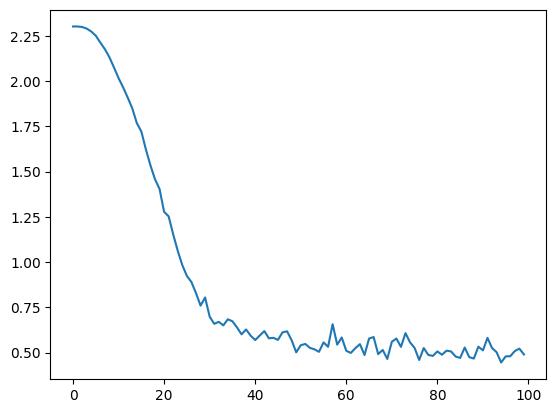

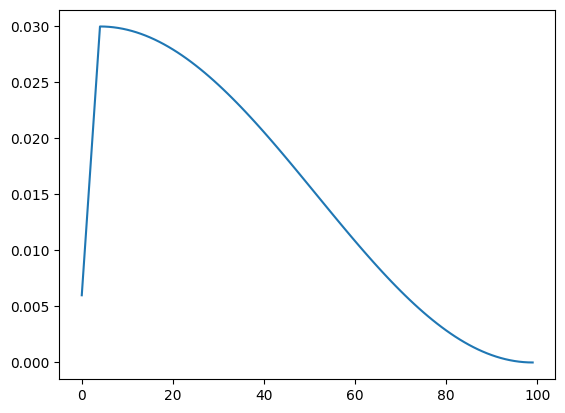

In [ ]:
losses = []
lrs = []
# Completes in ~20 min on the TPU runtime.
for step, batch in zip(
    tqdm.trange(1, total_steps + 1),
    ds_train.as_numpy_iterator(),
):

  params_repl, opt_state_repl, loss_repl, update_rng_repl = update_fn_repl(
      params_repl, opt_state_repl, batch, update_rng_repl)
  losses.append(loss_repl[0])
  lrs.append(lr_fn(step))

plt.plot(losses)
plt.figure()
plt.plot(lrs)

In [ ]:
# Should be ~96.7% for Mixer-B/16 or 97.7% for ViT-B/32 on CIFAR10 (both @224)
get_accuracy(params_repl)

INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
100%|██████████| 19/19 [00:30<00:00,  1.59s/it]


Array(0.9771793, dtype=float32)

### Inference

In [ ]:
# Download a pre-trained model.

if model_name.startswith('Mixer'):
  # Download model trained on imagenet2012
  ![ -e "$model_name"_imagenet2012.npz ] || gsutil cp gs://mixer_models/imagenet1k/"$model_name".npz "$model_name"_imagenet2012.npz
  model = models.MlpMixer(num_classes=1000, **model_config)
else:
  # Download model pre-trained on imagenet21k and fine-tuned on imagenet2012.
  ![ -e "$model_name"_imagenet2012.npz ] || gsutil cp gs://vit_models/imagenet21k+imagenet2012/"$model_name".npz "$model_name"_imagenet2012.npz
  model = models.VisionTransformer(num_classes=1000, **model_config)

import os
assert os.path.exists(f'{model_name}_imagenet2012.npz')

Copying gs://vit_models/imagenet21k+imagenet2012/ViT-B_32.npz...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

/ [1 files][336.9 MiB/336.9 MiB]   35.3 MiB/s                                   
Operation completed over 1 objects/336.9 MiB.                                    


In [ ]:
# Load and convert pretrained checkpoint.
params = checkpoint.load(f'{model_name}_imagenet2012.npz')
params['pre_logits'] = {}  # Need to restore empty leaf for Flax.

In [ ]:
# Get imagenet labels.
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

--2024-02-06 10:52:41--  https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.203.207, 172.253.123.207, 142.250.98.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.203.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21675 (21K) [text/plain]
Saving to: ‘ilsvrc2012_wordnet_lemmas.txt’

ilsvrc2012_wordnet_ 100%[===================>]  21.17K  --.-KB/s    in 0s      

2024-02-06 10:52:41 (59.2 MB/s) - ‘ilsvrc2012_wordnet_lemmas.txt’ saved [21675/21675]



--2024-02-06 10:52:41--  https://picsum.photos/384
Resolving picsum.photos (picsum.photos)... 104.26.5.30, 172.67.74.163, 104.26.4.30, ...
Connecting to picsum.photos (picsum.photos)|104.26.5.30|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://fastly.picsum.photos/id/997/384/384.jpg?hmac=VWE41G8Zk15BPtMQxAa0HPtjkgN80R-eoJVXHwwyE4k [following]
--2024-02-06 10:52:42--  https://fastly.picsum.photos/id/997/384/384.jpg?hmac=VWE41G8Zk15BPtMQxAa0HPtjkgN80R-eoJVXHwwyE4k
Resolving fastly.picsum.photos (fastly.picsum.photos)... 151.101.1.91, 151.101.65.91, 151.101.129.91, ...
Connecting to fastly.picsum.photos (fastly.picsum.photos)|151.101.1.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21922 (21K) [image/jpeg]
Saving to: ‘picsum.jpg’

picsum.jpg          100%[===================>]  21.41K  --.-KB/s    in 0.001s  

2024-02-06 10:52:42 (14.1 MB/s) - ‘picsum.jpg’ saved [21922/21922]



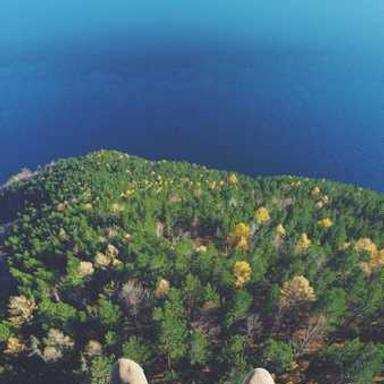

In [ ]:
# Get a random picture with the correct dimensions.
resolution = 224 if model_name.startswith('Mixer') else 384
!wget https://picsum.photos/$resolution -O picsum.jpg
import PIL
img = PIL.Image.open('picsum.jpg')
img

In [ ]:
# Predict on a batch with a single item (note very efficient TPU usage...)
logits, = model.apply(dict(params=params), (np.array(img) / 128 - 1)[None, ...], train=False)

In [ ]:
preds = np.array(jax.nn.softmax(logits))
for idx in preds.argsort()[:-11:-1]:
  print(f'{preds[idx]:.5f} : {imagenet_labels[idx]}', end='')

0.52548 : lakeside, lakeshore
0.16299 : promontory, headland, head, foreland
0.12497 : volcano
0.04307 : valley, vale
0.02912 : cliff, drop, drop-off
0.02730 : seashore, coast, seacoast, sea-coast
0.01116 : dam, dike, dyke
0.00892 : geyser
0.00597 : sandbar, sand_bar
0.00570 : alp
